참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

> 인용구 추가



In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=3462017bd987c6371b73d915410b6e76d809c3e4120952531533158e383a0d6a
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1234k      0  0:00:01  0:00:01 --:--:-- 4900k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [6]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [8]:
train_data['label'].value_counts()

label
1    80003
0    79923
Name: count, dtype: int64

### 데이터 정제 및 전처리

In [9]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

### 토큰화

In [10]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/KUBIG/NLP/1주차/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [11]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [12]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
# vocab_size 설
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [14]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


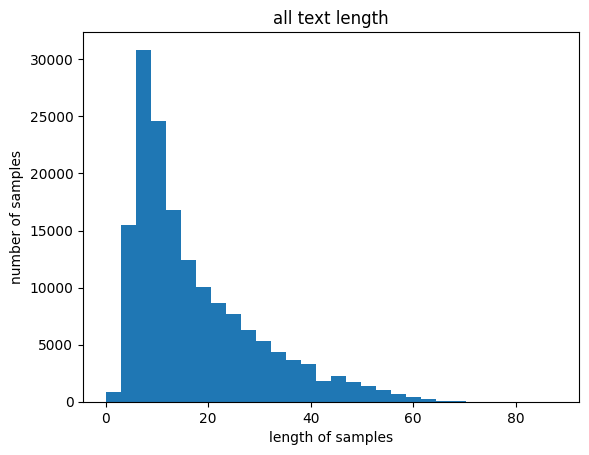

In [15]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [17]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [19]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [20]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [21]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [22]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.31059473752975464. Accuracy: 86.92662048339844
Iteration: 1000. Loss: 0.47818928956985474. Accuracy: 88.2472152709961
Iteration: 1500. Loss: 0.36734235286712646. Accuracy: 88.02461242675781
Iteration: 2000. Loss: 0.2758637070655823. Accuracy: 87.11170196533203
Iteration: 2500. Loss: 0.21248742938041687. Accuracy: 85.87614440917969
Iteration: 3000. Loss: 0.2945185601711273. Accuracy: 88.58235931396484
Iteration: 3500. Loss: 0.27375608682632446. Accuracy: 88.95753479003906
Iteration: 4000. Loss: 0.5067601203918457. Accuracy: 81.8968505859375
Iteration: 4500. Loss: 0.2358984351158142. Accuracy: 87.24176025390625
Iteration: 5000. Loss: 0.26131755113601685. Accuracy: 88.46981048583984
Iteration: 5500. Loss: 0.2512560784816742. Accuracy: 88.9425277709961
Iteration: 6000. Loss: 0.22423283755779266. Accuracy: 86.5939712524414
Iteration: 6500. Loss: 0.23731575906276703. Accuracy: 87.26927185058594
Iteration: 7000. Loss: 0.2655845284461975. Accuracy: 88.55985260009766
Ite

### 모델학습 (LSTM, Long short term memory)

In [24]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [25]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.25053414702415466. Accuracy: 90.67330169677734
Iteration: 2000. Loss: 0.238809272646904. Accuracy: 91.38111877441406
Iteration: 3000. Loss: 0.1057889312505722. Accuracy: 91.32359313964844
Iteration: 4000. Loss: 0.169737309217453. Accuracy: 91.42864227294922
Iteration: 5000. Loss: 0.20382604002952576. Accuracy: 91.68376159667969
Iteration: 6000. Loss: 0.14012163877487183. Accuracy: 91.40613555908203
Iteration: 7000. Loss: 0.1309804916381836. Accuracy: 91.31359100341797
Iteration: 8000. Loss: 0.20549429953098297. Accuracy: 91.2535629272461
Iteration: 9000. Loss: 0.15674735605716705. Accuracy: 91.02596282958984
Iteration: 10000. Loss: 0.06247374042868614. Accuracy: 91.13101196289062
Iteration: 11000. Loss: 0.23862811923027039. Accuracy: 90.76834869384766
Iteration: 12000. Loss: 0.0876796767115593. Accuracy: 90.69331359863281
Iteration: 13000. Loss: 0.23404979705810547. Accuracy: 90.5982666015625
Iteration: 14000. Loss: 0.22757750749588013. Accuracy: 90.66580200195

### 모델 학습 (Gated Recurrent Unit (GRU))

In [27]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [28]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [29]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.3209189176559448. Accuracy: 90.62078094482422
Iteration: 2000. Loss: 0.25149232149124146. Accuracy: 91.63123321533203
Iteration: 3000. Loss: 0.2874146103858948. Accuracy: 91.50367736816406
Iteration: 4000. Loss: 0.16505546867847443. Accuracy: 91.58871459960938
Iteration: 5000. Loss: 0.16062504053115845. Accuracy: 91.6012191772461
Iteration: 6000. Loss: 0.13174432516098022. Accuracy: 91.40613555908203
Iteration: 7000. Loss: 0.16957592964172363. Accuracy: 91.64124298095703
Iteration: 8000. Loss: 0.15636904537677765. Accuracy: 91.38612365722656
Iteration: 9000. Loss: 0.12889742851257324. Accuracy: 91.3436050415039
Iteration: 10000. Loss: 0.11011876165866852. Accuracy: 91.2935791015625
Iteration: 11000. Loss: 0.32038450241088867. Accuracy: 91.21354675292969
Iteration: 12000. Loss: 0.14639392495155334. Accuracy: 91.16602325439453
Iteration: 13000. Loss: 0.14827501773834229. Accuracy: 91.15351867675781
Iteration: 14000. Loss: 0.19009359180927277. Accuracy: 91.0534744

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

In [31]:
import torch

def compare(model, train_dataloader, test_dataloader, num_epoch, criterion, optimizer, device):
    model = model.to(device)
    iter = 0
    logs = []

    for epoch in range(num_epoch):
        for i, (text, labels) in enumerate(train_dataloader):
            model.train()

            text = text.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(text).to(device)
            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(logits, labels)
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 1000 == 0:
                model.eval()
                # Calculate Accuracy
                correct = 0
                total = 0
                # Iterate through test dataset
                for test_text, test_labels in test_dataloader:
                    test_text = test_text.to(device)
                    test_labels = test_labels.to(device)
                    # Forward pass only to get logits/output
                    outputs = model(test_text)

                    # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Total number of labels
                    total += test_labels.size(0)

                    # Total correct predictions
                    correct += (predicted == test_labels).sum().item()

                accuracy = 100 * correct / total

                log = 'Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy)
                print(log)
                logs.append(log)

    return logs  # Return the list of logs

## GRU Model :

- SGD / lr = 0.005
- SGD / lr = 0.001
- Adam / lr = 0.001

In [32]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
optimizer1 = torch.optim.SGD(model.parameters(), lr= 0.005)
optimizer2 = torch.optim.SGD(model.parameters(), lr= 0.001)
optimizer3 = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.CrossEntropyLoss()

In [33]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer1, device)

Iteration: 1000. Loss: 0.6748068332672119. Accuracy: 67.05267370316642
Iteration: 2000. Loss: 0.6249223351478577. Accuracy: 70.38167175228853
Iteration: 3000. Loss: 0.6197713613510132. Accuracy: 72.32004401980892
Iteration: 4000. Loss: 0.5295243263244629. Accuracy: 74.06082737231755
Iteration: 5000. Loss: 0.6381397247314453. Accuracy: 75.62653193937271
Iteration: 6000. Loss: 0.44841429591178894. Accuracy: 77.27977589915461
Iteration: 7000. Loss: 0.5195603966712952. Accuracy: 78.7779500775349
Iteration: 8000. Loss: 0.6261639595031738. Accuracy: 80.16857585913661
Iteration: 9000. Loss: 0.5607101321220398. Accuracy: 81.53419038567355
Iteration: 10000. Loss: 0.46825313568115234. Accuracy: 82.88479815917162
Iteration: 11000. Loss: 0.4016675353050232. Accuracy: 84.13786203791706
Iteration: 12000. Loss: 0.3539917469024658. Accuracy: 85.0057525886649
Iteration: 13000. Loss: 0.357454776763916. Accuracy: 85.64604071832325
Iteration: 14000. Loss: 0.29859068989753723. Accuracy: 86.11875343904757
I

['Iteration: 1000. Loss: 0.6748068332672119. Accuracy: 67.05267370316642',
 'Iteration: 2000. Loss: 0.6249223351478577. Accuracy: 70.38167175228853',
 'Iteration: 3000. Loss: 0.6197713613510132. Accuracy: 72.32004401980892',
 'Iteration: 4000. Loss: 0.5295243263244629. Accuracy: 74.06082737231755',
 'Iteration: 5000. Loss: 0.6381397247314453. Accuracy: 75.62653193937271',
 'Iteration: 6000. Loss: 0.44841429591178894. Accuracy: 77.27977589915461',
 'Iteration: 7000. Loss: 0.5195603966712952. Accuracy: 78.7779500775349',
 'Iteration: 8000. Loss: 0.6261639595031738. Accuracy: 80.16857585913661',
 'Iteration: 9000. Loss: 0.5607101321220398. Accuracy: 81.53419038567355',
 'Iteration: 10000. Loss: 0.46825313568115234. Accuracy: 82.88479815917162',
 'Iteration: 11000. Loss: 0.4016675353050232. Accuracy: 84.13786203791706',
 'Iteration: 12000. Loss: 0.3539917469024658. Accuracy: 85.0057525886649',
 'Iteration: 13000. Loss: 0.357454776763916. Accuracy: 85.64604071832325',
 'Iteration: 14000. Lo

In [34]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer2, device)

Iteration: 1000. Loss: 0.24479438364505768. Accuracy: 88.88499824921215
Iteration: 2000. Loss: 0.26827746629714966. Accuracy: 88.94752638687409
Iteration: 3000. Loss: 0.20718061923980713. Accuracy: 89.00005002251012
Iteration: 4000. Loss: 0.3637465536594391. Accuracy: 89.00005002251012
Iteration: 5000. Loss: 0.33142805099487305. Accuracy: 88.95502976339353
Iteration: 6000. Loss: 0.31546661257743835. Accuracy: 88.96503426541943
Iteration: 7000. Loss: 0.3961208760738373. Accuracy: 88.9350207593417
Iteration: 8000. Loss: 0.2955760955810547. Accuracy: 89.06758041118503
Iteration: 9000. Loss: 0.3942136764526367. Accuracy: 89.015056775549
Iteration: 10000. Loss: 0.4000394940376282. Accuracy: 88.9700365164324
Iteration: 11000. Loss: 0.18022343516349792. Accuracy: 88.95753088890001
Iteration: 12000. Loss: 0.2560766339302063. Accuracy: 89.0250612775749
Iteration: 13000. Loss: 0.4000985324382782. Accuracy: 89.06507928567855
Iteration: 14000. Loss: 0.19727708399295807. Accuracy: 89.05007253263969

['Iteration: 1000. Loss: 0.24479438364505768. Accuracy: 88.88499824921215',
 'Iteration: 2000. Loss: 0.26827746629714966. Accuracy: 88.94752638687409',
 'Iteration: 3000. Loss: 0.20718061923980713. Accuracy: 89.00005002251012',
 'Iteration: 4000. Loss: 0.3637465536594391. Accuracy: 89.00005002251012',
 'Iteration: 5000. Loss: 0.33142805099487305. Accuracy: 88.95502976339353',
 'Iteration: 6000. Loss: 0.31546661257743835. Accuracy: 88.96503426541943',
 'Iteration: 7000. Loss: 0.3961208760738373. Accuracy: 88.9350207593417',
 'Iteration: 8000. Loss: 0.2955760955810547. Accuracy: 89.06758041118503',
 'Iteration: 9000. Loss: 0.3942136764526367. Accuracy: 89.015056775549',
 'Iteration: 10000. Loss: 0.4000394940376282. Accuracy: 88.9700365164324',
 'Iteration: 11000. Loss: 0.18022343516349792. Accuracy: 88.95753088890001',
 'Iteration: 12000. Loss: 0.2560766339302063. Accuracy: 89.0250612775749',
 'Iteration: 13000. Loss: 0.4000985324382782. Accuracy: 89.06507928567855',
 'Iteration: 14000. 

In [35]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer3, device)

Iteration: 1000. Loss: 0.20853018760681152. Accuracy: 89.79040568255715
Iteration: 2000. Loss: 0.22279834747314453. Accuracy: 90.21809814416487
Iteration: 3000. Loss: 0.31095564365386963. Accuracy: 90.73332999849933
Iteration: 4000. Loss: 0.1929810494184494. Accuracy: 91.0409684357961
Iteration: 5000. Loss: 0.24387240409851074. Accuracy: 91.2460607273273
Iteration: 6000. Loss: 0.15033186972141266. Accuracy: 90.16057225751588
Iteration: 7000. Loss: 0.1293647289276123. Accuracy: 91.26106748036617
Iteration: 8000. Loss: 0.2317199558019638. Accuracy: 91.37862037917063
Iteration: 9000. Loss: 0.16433830559253693. Accuracy: 91.45615526987145
Iteration: 10000. Loss: 0.18216758966445923. Accuracy: 91.5286879095593
Iteration: 11000. Loss: 0.16339729726314545. Accuracy: 91.00595267870541
Iteration: 12000. Loss: 0.1539066731929779. Accuracy: 91.19603821719774
Iteration: 13000. Loss: 0.2038494348526001. Accuracy: 91.1560202090941
Iteration: 14000. Loss: 0.0742570012807846. Accuracy: 90.943424541043

['Iteration: 1000. Loss: 0.20853018760681152. Accuracy: 89.79040568255715',
 'Iteration: 2000. Loss: 0.22279834747314453. Accuracy: 90.21809814416487',
 'Iteration: 3000. Loss: 0.31095564365386963. Accuracy: 90.73332999849933',
 'Iteration: 4000. Loss: 0.1929810494184494. Accuracy: 91.0409684357961',
 'Iteration: 5000. Loss: 0.24387240409851074. Accuracy: 91.2460607273273',
 'Iteration: 6000. Loss: 0.15033186972141266. Accuracy: 90.16057225751588',
 'Iteration: 7000. Loss: 0.1293647289276123. Accuracy: 91.26106748036617',
 'Iteration: 8000. Loss: 0.2317199558019638. Accuracy: 91.37862037917063',
 'Iteration: 9000. Loss: 0.16433830559253693. Accuracy: 91.45615526987145',
 'Iteration: 10000. Loss: 0.18216758966445923. Accuracy: 91.5286879095593',
 'Iteration: 11000. Loss: 0.16339729726314545. Accuracy: 91.00595267870541',
 'Iteration: 12000. Loss: 0.1539066731929779. Accuracy: 91.19603821719774',
 'Iteration: 13000. Loss: 0.2038494348526001. Accuracy: 91.1560202090941',
 'Iteration: 1400

# LSTM Model :
- SGD / lr = 0.005
- SGD / lr = 0.001
- Adam / lr = 0.001


In [45]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [47]:
optimizer1 = torch.optim.SGD(model.parameters(), lr= 0.005)
optimizer2 = torch.optim.SGD(model.parameters(), lr= 0.001)
optimizer3 = torch.optim.Adam(model.parameters(), lr= 0.001)

In [48]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer1, device)

Iteration: 1000. Loss: 0.799645721912384. Accuracy: 62.42809264168876
Iteration: 2000. Loss: 0.7367976903915405. Accuracy: 64.5290380671302
Iteration: 3000. Loss: 0.7019026279449463. Accuracy: 66.93261967885549
Iteration: 4000. Loss: 0.6553659439086914. Accuracy: 69.1736281326597
Iteration: 5000. Loss: 0.6737236976623535. Accuracy: 71.32209494272422
Iteration: 6000. Loss: 0.5245092511177063. Accuracy: 72.96283327497373
Iteration: 7000. Loss: 0.4587998688220978. Accuracy: 74.9612325546496
Iteration: 8000. Loss: 0.49494510889053345. Accuracy: 76.67950577759991
Iteration: 9000. Loss: 0.43030357360839844. Accuracy: 78.61537691961382
Iteration: 10000. Loss: 0.4830315411090851. Accuracy: 80.25361412635687
Iteration: 11000. Loss: 0.46155309677124023. Accuracy: 80.72382572157471
Iteration: 12000. Loss: 0.3607066571712494. Accuracy: 82.34205392426593
Iteration: 13000. Loss: 0.41107794642448425. Accuracy: 83.77269771397128
Iteration: 14000. Loss: 0.2113751322031021. Accuracy: 84.10534740633285
I

['Iteration: 1000. Loss: 0.799645721912384. Accuracy: 62.42809264168876',
 'Iteration: 2000. Loss: 0.7367976903915405. Accuracy: 64.5290380671302',
 'Iteration: 3000. Loss: 0.7019026279449463. Accuracy: 66.93261967885549',
 'Iteration: 4000. Loss: 0.6553659439086914. Accuracy: 69.1736281326597',
 'Iteration: 5000. Loss: 0.6737236976623535. Accuracy: 71.32209494272422',
 'Iteration: 6000. Loss: 0.5245092511177063. Accuracy: 72.96283327497373',
 'Iteration: 7000. Loss: 0.4587998688220978. Accuracy: 74.9612325546496',
 'Iteration: 8000. Loss: 0.49494510889053345. Accuracy: 76.67950577759991',
 'Iteration: 9000. Loss: 0.43030357360839844. Accuracy: 78.61537691961382',
 'Iteration: 10000. Loss: 0.4830315411090851. Accuracy: 80.25361412635687',
 'Iteration: 11000. Loss: 0.46155309677124023. Accuracy: 80.72382572157471',
 'Iteration: 12000. Loss: 0.3607066571712494. Accuracy: 82.34205392426593',
 'Iteration: 13000. Loss: 0.41107794642448425. Accuracy: 83.77269771397128',
 'Iteration: 14000. L

In [49]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer2, device)

Iteration: 1000. Loss: 0.2582337558269501. Accuracy: 88.66239807913561
Iteration: 2000. Loss: 0.3498830497264862. Accuracy: 88.62738232204492
Iteration: 3000. Loss: 0.37258660793304443. Accuracy: 88.74493522084938
Iteration: 4000. Loss: 0.3660343289375305. Accuracy: 88.60237106698014
Iteration: 5000. Loss: 0.419119656085968. Accuracy: 88.64989245160322
Iteration: 6000. Loss: 0.24797621369361877. Accuracy: 88.7199239657846
Iteration: 7000. Loss: 0.23546084761619568. Accuracy: 88.732429593317
Iteration: 8000. Loss: 0.39625829458236694. Accuracy: 88.75493972287529
Iteration: 9000. Loss: 0.25975435972213745. Accuracy: 88.77494872692712
Iteration: 10000. Loss: 0.21478107571601868. Accuracy: 88.78995547996598
Iteration: 11000. Loss: 0.12697981297969818. Accuracy: 88.79745885648542
Iteration: 12000. Loss: 0.2534223794937134. Accuracy: 88.76994647591417
Iteration: 13000. Loss: 0.28320077061653137. Accuracy: 88.83247461357611
Iteration: 14000. Loss: 0.2906101644039154. Accuracy: 88.819968986043

['Iteration: 1000. Loss: 0.2582337558269501. Accuracy: 88.66239807913561',
 'Iteration: 2000. Loss: 0.3498830497264862. Accuracy: 88.62738232204492',
 'Iteration: 3000. Loss: 0.37258660793304443. Accuracy: 88.74493522084938',
 'Iteration: 4000. Loss: 0.3660343289375305. Accuracy: 88.60237106698014',
 'Iteration: 5000. Loss: 0.419119656085968. Accuracy: 88.64989245160322',
 'Iteration: 6000. Loss: 0.24797621369361877. Accuracy: 88.7199239657846',
 'Iteration: 7000. Loss: 0.23546084761619568. Accuracy: 88.732429593317',
 'Iteration: 8000. Loss: 0.39625829458236694. Accuracy: 88.75493972287529',
 'Iteration: 9000. Loss: 0.25975435972213745. Accuracy: 88.77494872692712',
 'Iteration: 10000. Loss: 0.21478107571601868. Accuracy: 88.78995547996598',
 'Iteration: 11000. Loss: 0.12697981297969818. Accuracy: 88.79745885648542',
 'Iteration: 12000. Loss: 0.2534223794937134. Accuracy: 88.76994647591417',
 'Iteration: 13000. Loss: 0.28320077061653137. Accuracy: 88.83247461357611',
 'Iteration: 1400

In [50]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer3, device)

Iteration: 1000. Loss: 0.29800230264663696. Accuracy: 89.52028412785754
Iteration: 2000. Loss: 0.06440375745296478. Accuracy: 90.34565554499525
Iteration: 3000. Loss: 0.24037937819957733. Accuracy: 90.98344254914711
Iteration: 4000. Loss: 0.19509616494178772. Accuracy: 91.09349207143214
Iteration: 5000. Loss: 0.3468433916568756. Accuracy: 91.32109449252164
Iteration: 6000. Loss: 0.19992689788341522. Accuracy: 91.36861587714472
Iteration: 7000. Loss: 0.2994891107082367. Accuracy: 91.56370366665
Iteration: 8000. Loss: 0.178349107503891. Accuracy: 91.34860687309289
Iteration: 9000. Loss: 0.07680635154247284. Accuracy: 91.57120704316942
Iteration: 10000. Loss: 0.10645134001970291. Accuracy: 91.61372617677955
Iteration: 11000. Loss: 0.10288165509700775. Accuracy: 91.37862037917063
Iteration: 12000. Loss: 0.13569632172584534. Accuracy: 91.45115301885849
Iteration: 13000. Loss: 0.14960819482803345. Accuracy: 91.506177780001
Iteration: 14000. Loss: 0.15093247592449188. Accuracy: 91.17102696213

['Iteration: 1000. Loss: 0.29800230264663696. Accuracy: 89.52028412785754',
 'Iteration: 2000. Loss: 0.06440375745296478. Accuracy: 90.34565554499525',
 'Iteration: 3000. Loss: 0.24037937819957733. Accuracy: 90.98344254914711',
 'Iteration: 4000. Loss: 0.19509616494178772. Accuracy: 91.09349207143214',
 'Iteration: 5000. Loss: 0.3468433916568756. Accuracy: 91.32109449252164',
 'Iteration: 6000. Loss: 0.19992689788341522. Accuracy: 91.36861587714472',
 'Iteration: 7000. Loss: 0.2994891107082367. Accuracy: 91.56370366665',
 'Iteration: 8000. Loss: 0.178349107503891. Accuracy: 91.34860687309289',
 'Iteration: 9000. Loss: 0.07680635154247284. Accuracy: 91.57120704316942',
 'Iteration: 10000. Loss: 0.10645134001970291. Accuracy: 91.61372617677955',
 'Iteration: 11000. Loss: 0.10288165509700775. Accuracy: 91.37862037917063',
 'Iteration: 12000. Loss: 0.13569632172584534. Accuracy: 91.45115301885849',
 'Iteration: 13000. Loss: 0.14960819482803345. Accuracy: 91.506177780001',
 'Iteration: 1400

# RNN Model :
- SGD / lr = 0.005
- SGD / lr = 0.001
- Adam / lr = 0.001

In [51]:
model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)

In [52]:
optimizer1 = torch.optim.SGD(model.parameters(), lr= 0.005)
optimizer2 = torch.optim.SGD(model.parameters(), lr= 0.001)
optimizer3 = torch.optim.Adam(model.parameters(), lr= 0.001)

In [55]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer1, device)

Iteration: 1000. Loss: 0.5812048316001892. Accuracy: 68.27572407583412
Iteration: 2000. Loss: 0.6522864699363708. Accuracy: 72.68770946926116
Iteration: 3000. Loss: 0.5119806528091431. Accuracy: 76.57695963183433
Iteration: 4000. Loss: 0.5380374193191528. Accuracy: 78.79045570506727
Iteration: 5000. Loss: 0.383343905210495. Accuracy: 77.45985693562103
Iteration: 6000. Loss: 0.39283549785614014. Accuracy: 82.77975088789955
Iteration: 7000. Loss: 0.4495973587036133. Accuracy: 80.29613325996698
Iteration: 8000. Loss: 0.44499707221984863. Accuracy: 83.34500525236356
Iteration: 9000. Loss: 0.26092231273651123. Accuracy: 85.03826722024911
Iteration: 10000. Loss: 0.4155360460281372. Accuracy: 85.85613526086739
Iteration: 11000. Loss: 0.3261858820915222. Accuracy: 85.24836176279325
Iteration: 12000. Loss: 0.3444654047489166. Accuracy: 85.48596868590866
Iteration: 13000. Loss: 0.3489668071269989. Accuracy: 85.95367915562002
Iteration: 14000. Loss: 0.37743428349494934. Accuracy: 86.4714121354609

['Iteration: 1000. Loss: 0.5812048316001892. Accuracy: 68.27572407583412',
 'Iteration: 2000. Loss: 0.6522864699363708. Accuracy: 72.68770946926116',
 'Iteration: 3000. Loss: 0.5119806528091431. Accuracy: 76.57695963183433',
 'Iteration: 4000. Loss: 0.5380374193191528. Accuracy: 78.79045570506727',
 'Iteration: 5000. Loss: 0.383343905210495. Accuracy: 77.45985693562103',
 'Iteration: 6000. Loss: 0.39283549785614014. Accuracy: 82.77975088789955',
 'Iteration: 7000. Loss: 0.4495973587036133. Accuracy: 80.29613325996698',
 'Iteration: 8000. Loss: 0.44499707221984863. Accuracy: 83.34500525236356',
 'Iteration: 9000. Loss: 0.26092231273651123. Accuracy: 85.03826722024911',
 'Iteration: 10000. Loss: 0.4155360460281372. Accuracy: 85.85613526086739',
 'Iteration: 11000. Loss: 0.3261858820915222. Accuracy: 85.24836176279325',
 'Iteration: 12000. Loss: 0.3444654047489166. Accuracy: 85.48596868590866',
 'Iteration: 13000. Loss: 0.3489668071269989. Accuracy: 85.95367915562002',
 'Iteration: 14000.

In [56]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer2, device)

Iteration: 1000. Loss: 0.31143561005592346. Accuracy: 89.1726276824571
Iteration: 2000. Loss: 0.27397045493125916. Accuracy: 89.22515131809314
Iteration: 3000. Loss: 0.2681853771209717. Accuracy: 89.17012655695063
Iteration: 4000. Loss: 0.1397269368171692. Accuracy: 89.11260067030163
Iteration: 5000. Loss: 0.2189818173646927. Accuracy: 89.30518733430044
Iteration: 6000. Loss: 0.22313670814037323. Accuracy: 89.13010854884698
Iteration: 7000. Loss: 0.43609416484832764. Accuracy: 89.22765244359962
Iteration: 8000. Loss: 0.3943425118923187. Accuracy: 89.30018508328747
Iteration: 9000. Loss: 0.3023492097854614. Accuracy: 89.38272222500125
Iteration: 10000. Loss: 0.2520565390586853. Accuracy: 89.07258266219799
Iteration: 11000. Loss: 0.35421961545944214. Accuracy: 89.30268620879396
Iteration: 12000. Loss: 0.2065657526254654. Accuracy: 89.34020309139113
Iteration: 13000. Loss: 0.16116604208946228. Accuracy: 89.08508828973038
Iteration: 14000. Loss: 0.30959028005599976. Accuracy: 89.3001850832

['Iteration: 1000. Loss: 0.31143561005592346. Accuracy: 89.1726276824571',
 'Iteration: 2000. Loss: 0.27397045493125916. Accuracy: 89.22515131809314',
 'Iteration: 3000. Loss: 0.2681853771209717. Accuracy: 89.17012655695063',
 'Iteration: 4000. Loss: 0.1397269368171692. Accuracy: 89.11260067030163',
 'Iteration: 5000. Loss: 0.2189818173646927. Accuracy: 89.30518733430044',
 'Iteration: 6000. Loss: 0.22313670814037323. Accuracy: 89.13010854884698',
 'Iteration: 7000. Loss: 0.43609416484832764. Accuracy: 89.22765244359962',
 'Iteration: 8000. Loss: 0.3943425118923187. Accuracy: 89.30018508328747',
 'Iteration: 9000. Loss: 0.3023492097854614. Accuracy: 89.38272222500125',
 'Iteration: 10000. Loss: 0.2520565390586853. Accuracy: 89.07258266219799',
 'Iteration: 11000. Loss: 0.35421961545944214. Accuracy: 89.30268620879396',
 'Iteration: 12000. Loss: 0.2065657526254654. Accuracy: 89.34020309139113',
 'Iteration: 13000. Loss: 0.16116604208946228. Accuracy: 89.08508828973038',
 'Iteration: 140

In [57]:
compare(model,train_dataloader, test_dataloader, num_epoch, criterion, optimizer3, device)

Iteration: 1000. Loss: 0.3381114602088928. Accuracy: 89.71287079185633
Iteration: 2000. Loss: 0.24027086794376373. Accuracy: 90.26812065429444
Iteration: 3000. Loss: 0.5791507363319397. Accuracy: 89.05757590915913
Iteration: 4000. Loss: 0.26815250515937805. Accuracy: 90.15306888099644
Iteration: 5000. Loss: 0.21012553572654724. Accuracy: 90.85838627382321
Iteration: 6000. Loss: 0.0882224515080452. Accuracy: 90.66329848431795
Iteration: 7000. Loss: 0.17407503724098206. Accuracy: 90.50072532639687
Iteration: 8000. Loss: 0.14194072782993317. Accuracy: 91.02846280826373
Iteration: 9000. Loss: 0.37338531017303467. Accuracy: 90.49322194987745
Iteration: 10000. Loss: 0.30687806010246277. Accuracy: 91.34110349657345
Iteration: 11000. Loss: 0.09819038212299347. Accuracy: 90.80086038717423
Iteration: 12000. Loss: 0.1391087770462036. Accuracy: 90.95092791756291
Iteration: 13000. Loss: 0.09899234771728516. Accuracy: 90.96093241958881
Iteration: 14000. Loss: 0.16716544330120087. Accuracy: 90.508228

['Iteration: 1000. Loss: 0.3381114602088928. Accuracy: 89.71287079185633',
 'Iteration: 2000. Loss: 0.24027086794376373. Accuracy: 90.26812065429444',
 'Iteration: 3000. Loss: 0.5791507363319397. Accuracy: 89.05757590915913',
 'Iteration: 4000. Loss: 0.26815250515937805. Accuracy: 90.15306888099644',
 'Iteration: 5000. Loss: 0.21012553572654724. Accuracy: 90.85838627382321',
 'Iteration: 6000. Loss: 0.0882224515080452. Accuracy: 90.66329848431795',
 'Iteration: 7000. Loss: 0.17407503724098206. Accuracy: 90.50072532639687',
 'Iteration: 8000. Loss: 0.14194072782993317. Accuracy: 91.02846280826373',
 'Iteration: 9000. Loss: 0.37338531017303467. Accuracy: 90.49322194987745',
 'Iteration: 10000. Loss: 0.30687806010246277. Accuracy: 91.34110349657345',
 'Iteration: 11000. Loss: 0.09819038212299347. Accuracy: 90.80086038717423',
 'Iteration: 12000. Loss: 0.1391087770462036. Accuracy: 90.95092791756291',
 'Iteration: 13000. Loss: 0.09899234771728516. Accuracy: 90.96093241958881',
 'Iteration:

# <정리>

## LSTM:
- Adam / lr = 0.005 : Iteration: 37000. Loss: 0.09369441121816635. Accuracy: 89.9129638671875
- SGD / lr = 0.005 : Iteration: 37000. Loss: 0.3291831612586975. Accuracy: 88.56735530988945
- SGD / lr = 0.001 : Iteration: 37000. Loss: 0.301301509141922. Accuracy: 88.92251513180932
- Adam / lr = 0.001 : Iteration: 37000. Loss: 0.007833229377865791. Accuracy: 90.04051823320495

## RNN
- Adam / lr = 0.005 : Iteration: 37000. Loss: 0.3744024932384491. Accuracy: 88.82747650146484
- SGD / lr = 0.005 : Iteration: 37000. Loss: 0.4241499602794647. Accuracy: 89.05007253263969
- SGD / lr = 0.001 : Iteration: 37000. Loss: 0.14033840596675873. Accuracy: 89.40273122905307
- Adam / lr = 0.001 : Iteration: 37000. Loss: 0.148285374045372. Accuracy: 90.3731679255665

## GRU
- Adam / lr = 0.005 :
Iteration: 37000. Loss: 0.04808371141552925. Accuracy: 90.02801513671875
- SGD / lr = 0.005 : Iteration: 37000. Loss: 0.3987571895122528. Accuracy: 88.77244760142064

- SGD / lr = 0.001 : Iteration: 37000. Loss: 0.26236510276794434. Accuracy: 89.21014456505428
- Adam / lr = 0.001 : Iteration: 37000. Loss: 0.010709119960665703. Accuracy: 89.49277174728628



> Optimizer은 SGD보다 adam일때 loss가 더 또한 성능 또한 더 좋다.
> 학습률을 0.001로 낮추는 것이 정확도와 LOSS 차원에서 좋다.

> 정확도 차원에서 GRU > lstm > rnn
> loss 차원에서 GRU > lstm > rnn
gru와 lstm이 loss가 작지만 rnn의 loss가 크다. rnn이 긴 시퀀스의 정보를 잘 기억하지 못하고 긴 시퀀스를 학습할때 기울기 소실 문제가 발생할 수 있기 때문이라고 생각.

